## Plotting Test with Julia
###### https://docs.juliaplots.org/latest/tutorial

### The Homogeneous sphere
In the homogeneous source the magnetic field is constant over the sphere and is parameterized by:

${n_{e0}}$ : The normalization of the electron density

${\gamma_{min}}$ and ${\gamma_{max}}$ : The range ofelectron Lorentz factors

${p}$ : The spectral index of the electrons

${B_{0}}$ : The magnetic field strength

${r}$ : The size of the Blob

###### Electron distribution

${dn_{e} = n_{e0} \gamma^{-p} d\gamma}$ with ${\gamma_{min} \leqslant \gamma \leqslant \gamma_{max}}$

${n_{e} = n_{e0} \int_{\gamma_{min}}^{\gamma_{max}} \gamma^{-p} d\gamma}$

In [ ]:
# Package needed to calculate the integration

using Nintegrate

In [ ]:
# Generating function to calculate electron distribution (I have not yet tested this part)

function elec_dis(n_e0,gamma_min,gamma_max,p)
    using NIntegration
    gamma_func = gamma**(-p)
    dn_e = n_e0*nintegrate(gamma_func, gamma_min, gamma_max)
end 

### Comoving Volume synchrotron emissivity
For an isotropic electron distribution in a randomly oriented magnetic fiels, the synchrotron emissivity is:

$${j_{sync}(\epsilon, \Omega; x) = \frac{c \sigma_{T} u_{H}}{6 \pi \epsilon_H} \left(\frac{\epsilon}{\epsilon_H}\right)^{\tiny{1/2}} \small{n_e} \left[\left(\frac{\epsilon}{\epsilon_H}\right)^{\tiny{1/2}};x \right]}$$


where ${u_H \equiv {H^2}/{8\pi}}$ is the energy density of the magnetic field with strength ${H \equiv 4.414 \times 10^{13} \epsilon_H}$ G

${\epsilon \equiv h\nu/m_ec^2}$ is the dimentionless photon energy in units of the electron rest mass energy

${c}$ : The speed of light

${\sigma_{T}}$ : The Thomson cross-section

${\epsilon_H}$ : The cyclotron energy in units of ${m_e c^2}$

${n_e \left( \gamma , \Omega ; x \right)}$ : The differential electron density ( ${electrons}$ ${cm^3}$ ${gamma^{-1}}$ ${sr^{-1}}$) at location ${x}$ in ${cm}$

${\Omega = \left( \mu, \phi \right)}$ : Photon direction specified by direction cosine ${\mu}$ and azimuthal angle ${\phi}$

${h}$ : The constant of Planck

${m_e}$ : The mass of electrons

In [1]:
# Package needed to run the code

using Random
using Plots
using LaTeXStrings

In [2]:
# Define the x array (Here I just generate sequence of 500 numbers, value of x to be decided)

x = [1:1:500;]               #x : Location of the blob
length(x)

500

In [3]:
# Define all the parameters (Units conversion to be done later)

m_e = 9.109*10^(-31)         #m_e : electron mass in Kg
c = 3*10^8                   #c : speed of light in m s-1
h = 6.63*10^(-34)            #h : Constant of Planck in J Hz-1

sigma_T = 6.65*10^(-29)      #sigma_T : Thomson cross-section in m^2 (Value TBC)
nu = 10^16                   #nu : Photon frequency in Hz (Value TBD)
epsilon_H = 1                #epsilon_H : cyclotron energy in units of m_e*c^2 (Value TBD)

H = 4.414*epsilon_H*10^13    #H : magnetic field strength in Gauss
u_H = H^2 / 8*pi             #u_H : magnetic field energy density in Gauss

epsilon = (h*nu)/(m_e*c^2)   #epsilon : photon energy density in units of the electron rest mass energy

# Generate the n_e value (This still need to be studied)
# Here I just generate 500 random number
ne = MersenneTwister(1234)
n_e = randexp!(ne, zeros(500));  #n_e : differential electron density (electrons cm-3 gamma-1 sr-1) at location x (cm)

In [4]:
# Define the J_sync array in function of x

J_sync = zeros(500)            #J_sync : synchrotron emissivity in ergs cm-3 s-1 sr-1 epsilon-1

# Calculate J_sync
# The equation looks like below but I wonder if we still have to integrate it 
# as J_sync is in function of the photon energy epsilon, photon direction Omega and the location x.

for i in x
    J_sync[i] = (((c*sigma_T*u_H)/(6*pi*epsilon_H))*sqrt(epsilon/epsilon_H))*n_e[i]
end

println(J_sync)

[18085.544249786617, 11045.037580266659, 4401.666674534494, 5067.484902864314, 9514.422184181665, 20246.790788137696, 5048.736765250282, 2508.2690252140233, 3047.744673365569, 4687.184460099071, 4942.995265341381, 77.98740934228195, 681.0759416283921, 9969.856326909552, 11622.285884629946, 1079.4729778168883, 2318.491951253989, 2355.6548605451185, 995.0786249125767, 6288.369990766703, 4120.457380520715, 27559.439324252508, 13329.02798278145, 19282.526446919146, 381.83005169045276, 513.9892615862889, 286.0806857663033, 6475.8644545848965, 2606.501144935166, 1317.2336878615504, 21063.266407666488, 7483.188843072945, 3909.046128047342, 425.09703475664344, 1620.4656686160758, 5507.652452286941, 11591.163029415842, 1811.252323667043, 2578.0094870555754, 6121.616474693882, 294.9088379224985, 1385.89574278771, 1066.7588842496925, 3331.55940239376, 20883.765995133475, 911.5558976345122, 1901.8411158061263, 7895.14078594697, 8839.203927529361, 6030.832988037688, 5951.242221848082, 5768.24502103

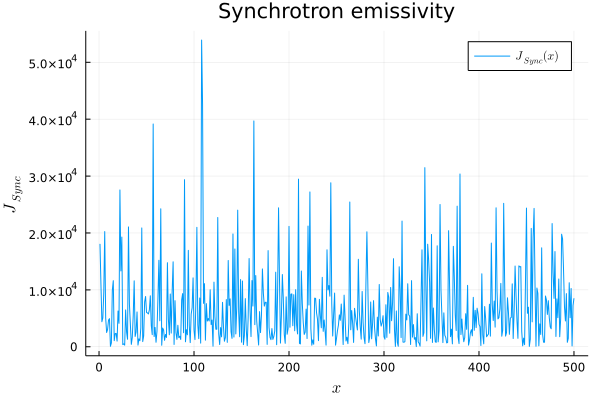

In [5]:
# Plotting the synchrotron emissivity
# The feature of the plot below may not be the required feature for the synchrotron emissivity
# But I just tested how to plot with Julia
# Values of some parameters still need to be fixed

plot(x, J_sync, label = L"J_{Sync} (x)", title = "Synchrotron emissivity")
xlabel!(L"x")
ylabel!(L"J_{Sync}")